In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Convoltional Layer

In [24]:
img = cv2.imread("./background3.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

(835, 1440)

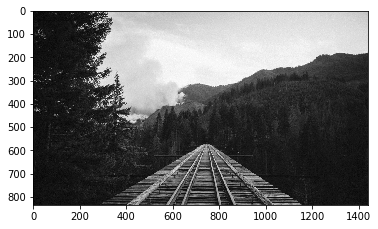

In [25]:
plt.imshow(img, cmap='gray')
img.shape

In [26]:
kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])

In [27]:
new_img = np.zeros((img.shape[0]-kernel.shape[0], img.shape[1]-kernel.shape[1]))

In [28]:
for ix in range(new_img.shape[0]):
    for iy in range(new_img.shape[1]):
        patch = img[ix:ix+kernel.shape[0], iy:iy+kernel.shape[1]]
        prod = patch*kernel
        
        new_img[ix, iy] = max(0,prod.sum())

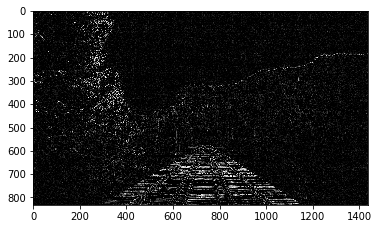

In [29]:
plt.imshow(new_img.astype(np.uint8), cmap='gray')

# CNN

In [88]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [89]:
ds = pd.read_csv("./mnist_train.csv")

In [90]:
ds = np.asarray(ds)
ds.shape

(60000, 785)

In [91]:
X_train = ds[0:10000, 1:].reshape((-1, 1, 28, 28)) / 255.0
y_train = ds[:10000, 0]

X_test = ds[5000:5100, 1:].reshape((-1, 1, 28, 28)) / 255.0
y_test = ds[5000:5100, 0]

In [92]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
        nn.Conv2d(
            in_channels = 1,
            out_channels = 16,
            kernel_size = 5,
            stride = 1,
            padding = 2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
        )
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(32*7*7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = F.softmax(self.out(x))
        return output    

In [93]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [94]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.003)
loss_func = nn.CrossEntropyLoss()

In [95]:
def make_batch(train, labels, batch_size=10, gpu=True):
    start = 0
    stop = start + batch_size
    while start < train.shape[0]:
        yield Variable(torch.FloatTensor(train[start:stop]), requires_grad=True), Variable(torch.LongTensor(labels[start:stop]))
        start = stop
        stop = start + batch_size

In [96]:
for epoch in range(20):
    for step, (b_x, b_y) in enumerate(make_batch(X_train, y_train, 128)):   # gives batch data, normalize x when iterate train_loader
        # print step,
        output = cnn(b_x)               # cnn output
        # print output.size(), output.sum(dim=0)
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        
        # for params in cnn.parameters():
        #     print params.grad.cpu().data.sum() # Y U no train!!!
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            test_output = cnn(torch.FloatTensor(X_test))
            outs = test_output.data.numpy().argmax(axis=1)
            acc = (outs == y_test).sum()*100.0 / test_output.shape[0]
            # pred_y = torch.max(test_output, 1)[1].data.squeeze().numpy()
            # accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| Step: ', step, '| Acc: ', acc)

/home/gautam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch:  0 | Step:  0 | Acc:  12.0
Epoch:  1 | Step:  0 | Acc:  71.0
Epoch:  2 | Step:  0 | Acc:  78.0
Epoch:  3 | Step:  0 | Acc:  80.0
Epoch:  4 | Step:  0 | Acc:  80.0
Epoch:  5 | Step:  0 | Acc:  81.0
Epoch:  6 | Step:  0 | Acc:  79.0
Epoch:  7 | Step:  0 | Acc:  91.0
Epoch:  8 | Step:  0 | Acc:  99.0
Epoch:  9 | Step:  0 | Acc:  99.0
Epoch:  10 | Step:  0 | Acc:  99.0
Epoch:  11 | Step:  0 | Acc:  99.0
Epoch:  12 | Step:  0 | Acc:  100.0
Epoch:  13 | Step:  0 | Acc:  100.0
Epoch:  14 | Step:  0 | Acc:  99.0
Epoch:  15 | Step:  0 | Acc:  100.0
Epoch:  16 | Step:  0 | Acc:  100.0
Epoch:  17 | Step:  0 | Acc:  99.0
Epoch:  18 | Step:  0 | Acc:  99.0
Epoch:  19 | Step:  0 | Acc:  100.0


In [98]:
print (cnn.state_dict().keys())

odict_keys(['conv1.0.weight', 'conv1.0.bias', 'conv2.0.weight', 'conv2.0.bias', 'out.weight', 'out.bias'])


In [99]:
conv_01 = cnn.state_dict()['conv1.0.weight']
print( conv_01.shape)

torch.Size([16, 1, 5, 5])


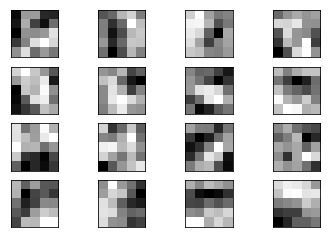

In [100]:
plt.figure(0)
for ix in range(conv_01.shape[0]):
    plt.subplot(4, 4, ix+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(conv_01[ix].reshape((5, 5)), cmap='gray')
plt.show()
